core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.6.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...



Loading session: 2021 Abu Dhabi (R) ...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!


Drivers in this session:
  ALO  —  Fernando Alonso
  BOT  —  Valtteri Bottas
  GAS  —  Pierre Gasly
  GIO  —  Antonio Giovinazzi
  HAM  —  Lewis Hamilton
  LAT  —  Nicholas Latifi
  LEC  —  Charles Leclerc
  MSC  —  Mick Schumacher
  NOR  —  Lando Norris
  OCO  —  Esteban Ocon
  PER  —  Sergio Perez
  RAI  —  Kimi Räikkönen
  RIC  —  Daniel Ricciardo
  RUS  —  George Russell
  SAI  —  Carlos Sainz
  STR  —  Lance Stroll
  TSU  —  Yuki Tsunoda
  VER  —  Max Verstappen
  VET  —  Sebastian Vettel

Comparing: VER (Max Verstappen) vs HAM (Lewis Hamilton)
Fastest clean laps — VER: Lap 39, 0 days 00:01:26.103000 | HAM: Lap 43, 0 days 00:01:26.615000


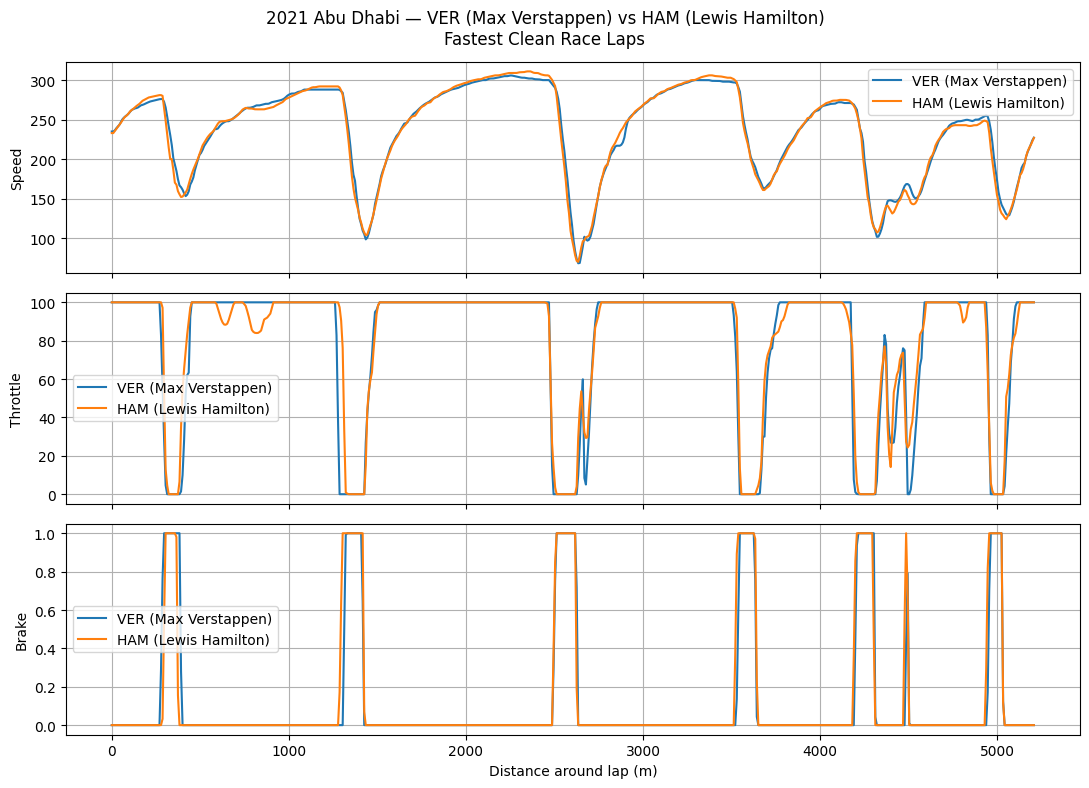

Integrated lap (approx): VER=85.986s | HAM=86.550s | Δ(A-B)=-0.564s


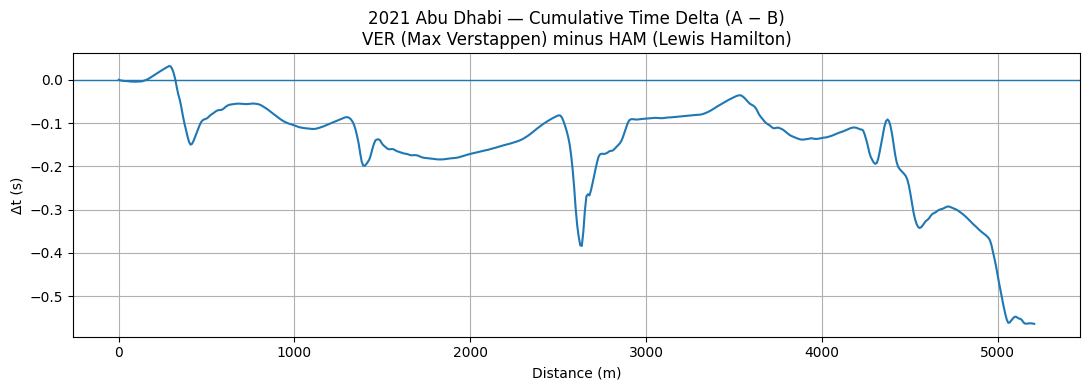

In [3]:
# compare_drivers.py  —  interactive telemetry comparator for any two drivers in a session
import fastf1 as ff1
from fastf1 import plotting
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# ----- setup -----
ff1.Cache.enable_cache("cache")
plotting.setup_mpl()

def _driver_directory(session):
    """Return (code->name, name->code) dicts for all drivers present in this session."""
    code_to_name, name_to_code = {}, {}
    codes = sorted(session.laps['Driver'].dropna().unique())
    for code in codes:
        meta = session.get_driver(code)
        full = None
        for k in ("FullName", "BroadcastName", "LastName", "Surname", "FirstName"):
            try:
                v = meta.get(k, None)
                if isinstance(v, str) and v.strip():
                    if k in ("FullName", "BroadcastName"):
                        full = v
                        break
                    if full is None:
                        full = v
            except Exception:
                pass
        if not full:
            full = code
        code_u = code.upper()
        code_to_name[code_u] = full
        # map various forms back to code
        name_to_code[code_u] = code_u
        name_to_code[full.upper()] = code_u
        for part in full.upper().split():
            name_to_code.setdefault(part, code_u)
    return code_to_name, name_to_code

def _resolve_code(inp, name_to_code):
    key = str(inp).strip().upper()
    return name_to_code.get(key)

def _clean_race_laps(laps_df):
    """Filter to clean green-flag race laps (no in/out, no SC/VSC, valid LapTime)."""
    df = laps_df.copy()
    df = df[df['LapTime'].notna()]
    df = df[df['PitOutTime'].isna()]
    df = df[df['PitInTime'].isna()]
    ts = df['TrackStatus'].astype(str).fillna('')
    df = df[(ts == '1') | (ts == '')]  # keep green only
    return df

def _fastest_clean_lap(laps_df):
    cl = _clean_race_laps(laps_df)
    if cl.empty:
        raise RuntimeError("No clean race laps after filtering")
    try:
        return cl.pick_fastest()
    except Exception:
        return cl.sort_values('LapTime', ascending=True).iloc[0]

def _cumulative_time_from_speed(dist, speed_kmh, min_mps=1.0):
    """Integrate dt over distance using speed; returns cumulative time in seconds."""
    v = np.maximum(speed_kmh / 3.6, min_mps)
    ds = np.diff(dist)
    inv_v = 1.0 / v
    seg_dt = 0.5 * (inv_v[1:] + inv_v[:-1]) * ds
    cum_t = np.empty_like(dist, dtype=float)
    cum_t[0] = 0.0
    cum_t[1:] = np.cumsum(seg_dt)
    return cum_t

# ----- interactive prompts -----
def _ask(prompt, default=None):
    s = input(f"{prompt}" + (f" [{default}]" if default is not None else "") + ": ").strip()
    return s if s else default

def main():
    # 1) session selection (defaults to 2025 Azerbaijan Race)
    year = int(_ask("Year", 2025))
    event_name = _ask("Event (e.g., Azerbaijan, Monza, Zandvoort)", "Azerbaijan")
    sess_kind = _ask("Session kind (R=Race, Q=Quali, S=Sprint)", "R").upper()

    print(f"\nLoading session: {year} {event_name} ({sess_kind}) ...")
    session = ff1.get_session(year, event_name, sess_kind)
    session.load()
    laps = session.laps.copy()

    # 2) available drivers overview
    code_to_name, name_to_code = _driver_directory(session)
    print("\nDrivers in this session:")
    for c, n in code_to_name.items():
        print(f"  {c:>3}  —  {n}")

    # 3) driver inputs
    drv_a_in = _ask("\nEnter Driver A (code or name)", "ALB")
    drv_b_in = _ask("Enter Driver B (code or name)", "SAI")

    drv_a = _resolve_code(drv_a_in, name_to_code)
    drv_b = _resolve_code(drv_b_in, name_to_code)
    if not drv_a:
        raise ValueError(f"Could not resolve '{drv_a_in}' to a driver in this session.")
    if not drv_b:
        raise ValueError(f"Could not resolve '{drv_b_in}' to a driver in this session.")
    if drv_a == drv_b:
        raise ValueError("Pick two different drivers.")

    name_a = code_to_name[drv_a]
    name_b = code_to_name[drv_b]
    print(f"\nComparing: {drv_a} ({name_a}) vs {drv_b} ({name_b})")

    # 4) select fastest clean lap for each
    laps_a = laps[laps['Driver'] == drv_a]
    laps_b = laps[laps['Driver'] == drv_b]
    fast_a = _fastest_clean_lap(laps_a)
    fast_b = _fastest_clean_lap(laps_b)

    lapnum_a = int(fast_a['LapNumber'])
    lapnum_b = int(fast_b['LapNumber'])
    print(f"Fastest clean laps — {drv_a}: Lap {lapnum_a}, {fast_a['LapTime']} | "
          f"{drv_b}: Lap {lapnum_b}, {fast_b['LapTime']}")

    tele_a = fast_a.get_car_data().add_distance()
    tele_b = fast_b.get_car_data().add_distance()

    # 5) align on a common distance grid
    max_dist = min(tele_a['Distance'].max(), tele_b['Distance'].max())
    dist_grid = np.linspace(0, max_dist, 600)

    def interp_channel(df, ch):
        return np.interp(dist_grid, df['Distance'], df[ch])

    channels = ['Speed', 'Throttle', 'Brake']
    interp_a = {ch: interp_channel(tele_a, ch) for ch in channels}
    interp_b = {ch: interp_channel(tele_b, ch) for ch in channels}

    # 6) plots: Speed / Throttle / Brake
    fig, axes = plt.subplots(len(channels), 1, figsize=(11, 8), sharex=True)
    fig.suptitle(f"{year} {event_name} — {drv_a} ({name_a}) vs {drv_b} ({name_b})\nFastest Clean Race Laps")
    for ax, ch in zip(axes, channels):
        ax.plot(dist_grid, interp_a[ch], label=f"{drv_a} ({name_a})")
        ax.plot(dist_grid, interp_b[ch], label=f"{drv_b} ({name_b})")
        ax.set_ylabel(ch)
        ax.grid(True)
        ax.legend()
    axes[-1].set_xlabel("Distance around lap (m)")
    plt.tight_layout()
    plt.show()

    # 7) cumulative time delta
    cum_t_a = _cumulative_time_from_speed(dist_grid, interp_a['Speed'])
    cum_t_b = _cumulative_time_from_speed(dist_grid, interp_b['Speed'])
    delta_s = cum_t_a - cum_t_b
    print(f"Integrated lap (approx): {drv_a}={cum_t_a[-1]:.3f}s | {drv_b}={cum_t_b[-1]:.3f}s | Δ(A-B)={delta_s[-1]:.3f}s")

    plt.figure(figsize=(11, 4))
    plt.title(f"{year} {event_name} — Cumulative Time Delta (A − B)\n"
              f"{drv_a} ({name_a}) minus {drv_b} ({name_b})")
    plt.plot(dist_grid, delta_s)
    plt.axhline(0, linewidth=1)
    plt.xlabel("Distance (m)")
    plt.ylabel("Δt (s)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
